# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [3]:

from sklearn.datasets import load_iris, fetch_kddcup99, fetch_openml
import pandas as pd

In [4]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [5]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("f1", default=0.0))

# Varying Objective scorer

> :warning: This is useless as oob does not rely on the scorer. It relies on point wise error metrics.  :warning:

In [6]:
def oob_func(utility, scorer_name):
    
    return(compute_data_oob(Utility(utility.model, utility.data, Scorer(scorer_name)), n_est=30, max_samples=0.6, progress=False))
scorer_name_list = ["accuracy"]#, "f1", "roc_auc", "balanced_accuracy","neg_log_loss"]
func = oob_func
kwargs_list = [{"scorer_name":scorer_name} for scorer_name in scorer_name_list]

roc_auc_ovo_weighted


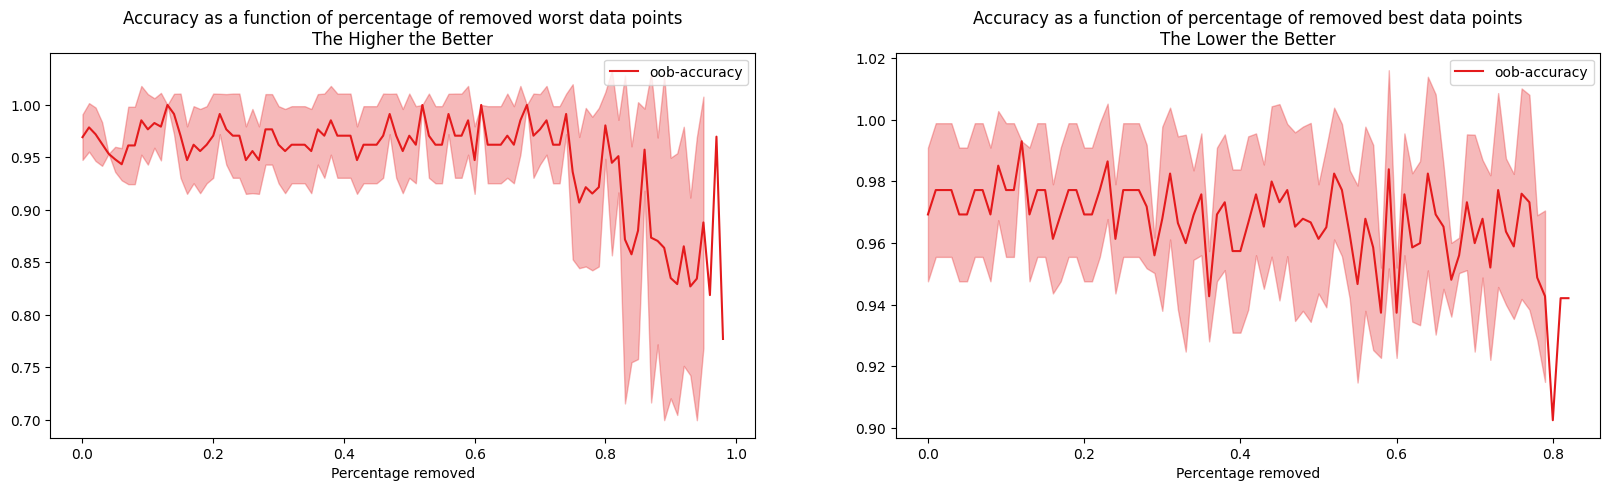

accuracy


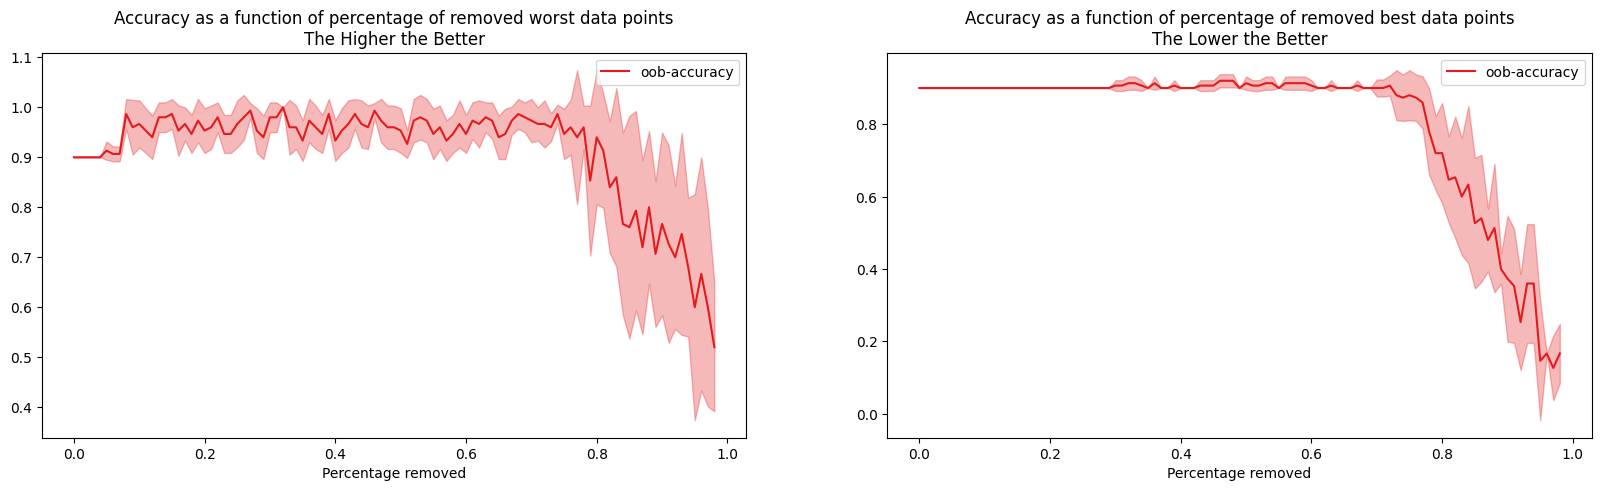

balanced_accuracy


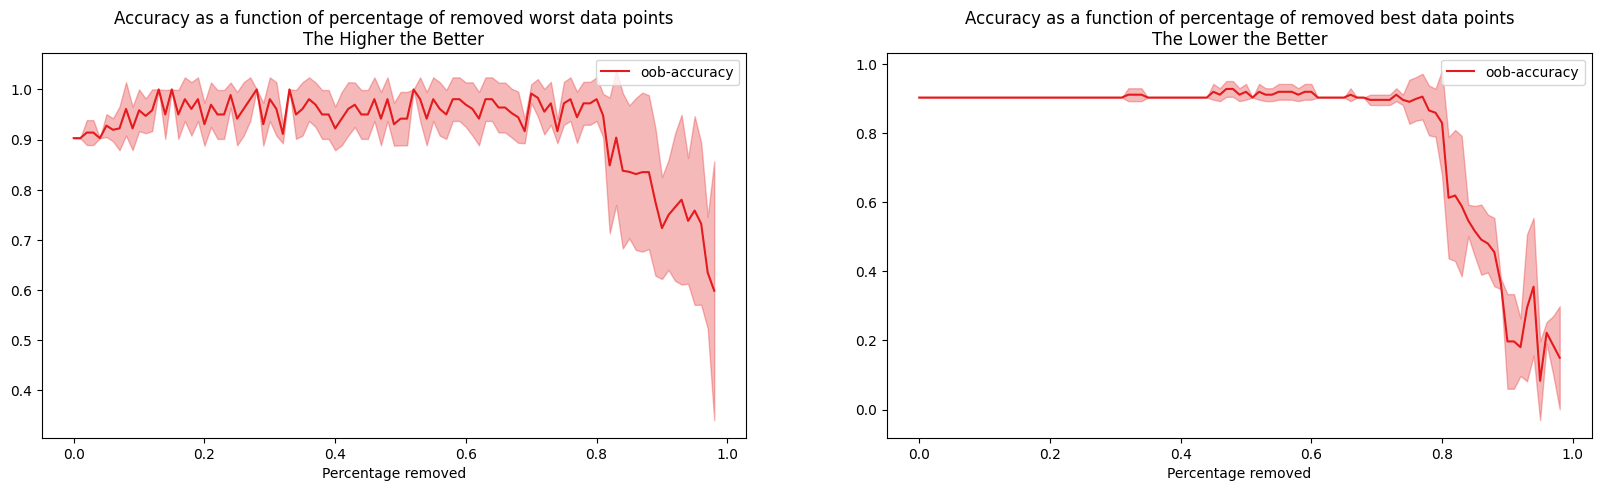

neg_log_loss


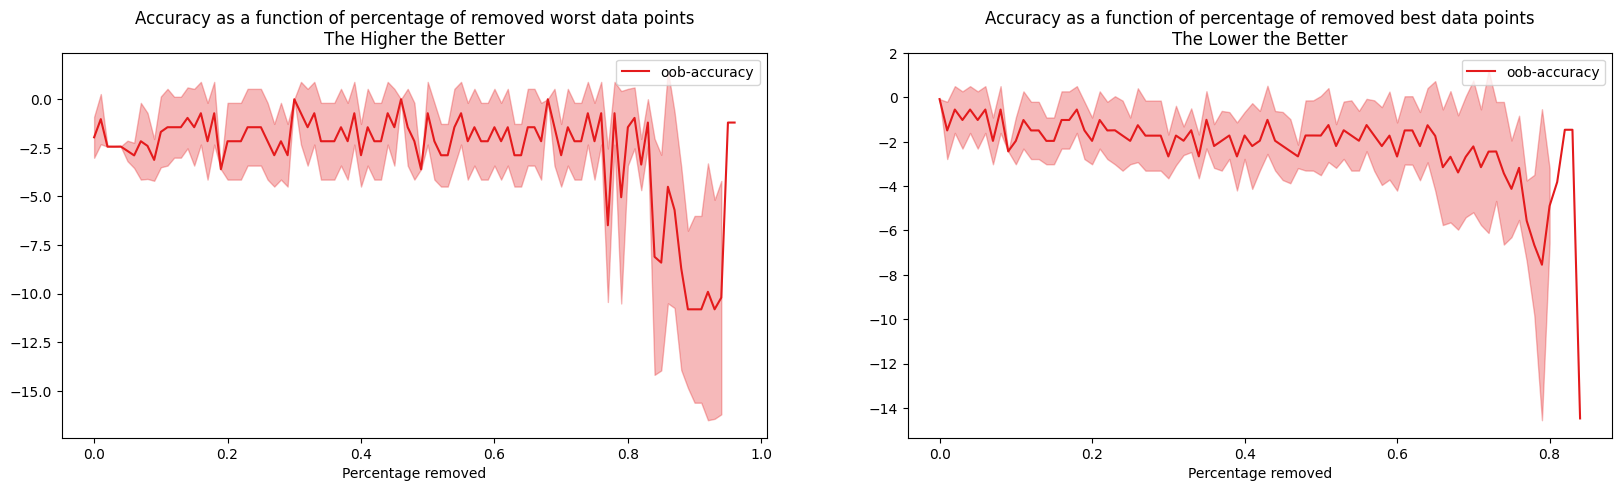

In [7]:
model_eval = DecisionTreeClassifier(max_depth=3)
for m in  ["roc_auc_ovo_weighted","accuracy",  "balanced_accuracy","neg_log_loss"]:#,  "f1", "roc_auc", "recall","jaccard","neg_brier_score","average_precision"
    print(m)
    utility_eval = Utility(model_eval, data, Scorer(m))
    n_iter = 5
    removal_percentages = np.arange(0, 0.99, 0.01)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="oob-", return_values=True)
    plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

# Varying cardinality

# Varying number of estimators

In [8]:
def oob_func(utility, n_est):
    return(compute_data_oob(utility, n_est=n_est, max_samples=0.6, progress=False))
n_est_list = [20,30, 50, 100, 1000]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [9]:

model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

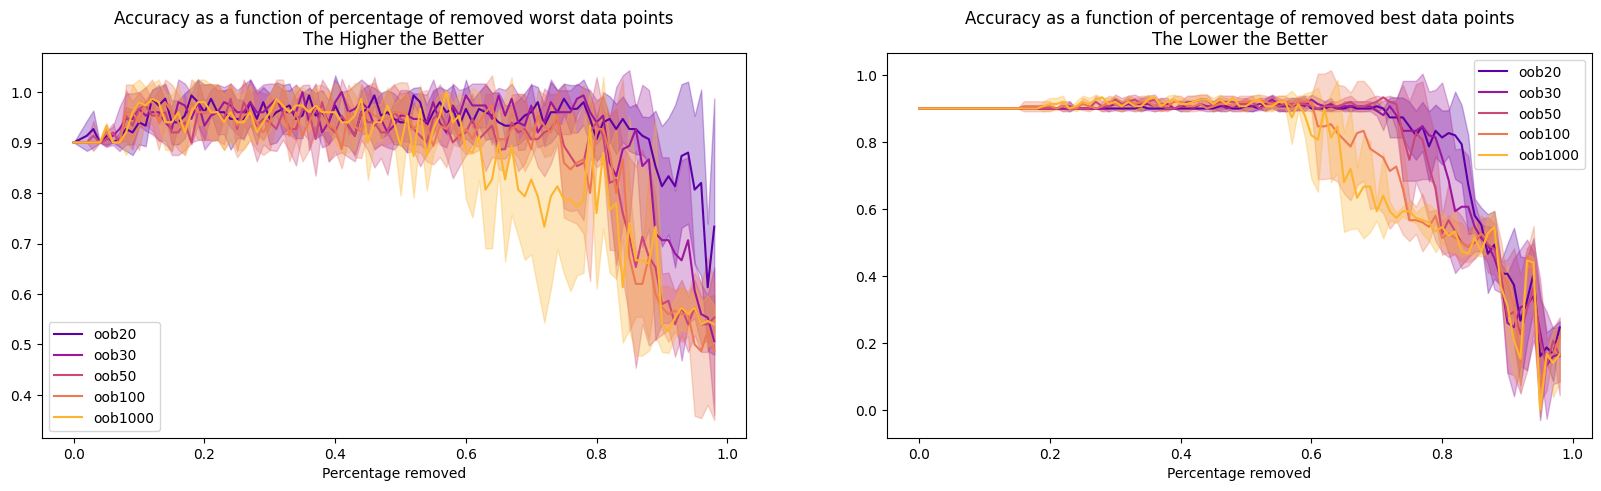

In [10]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

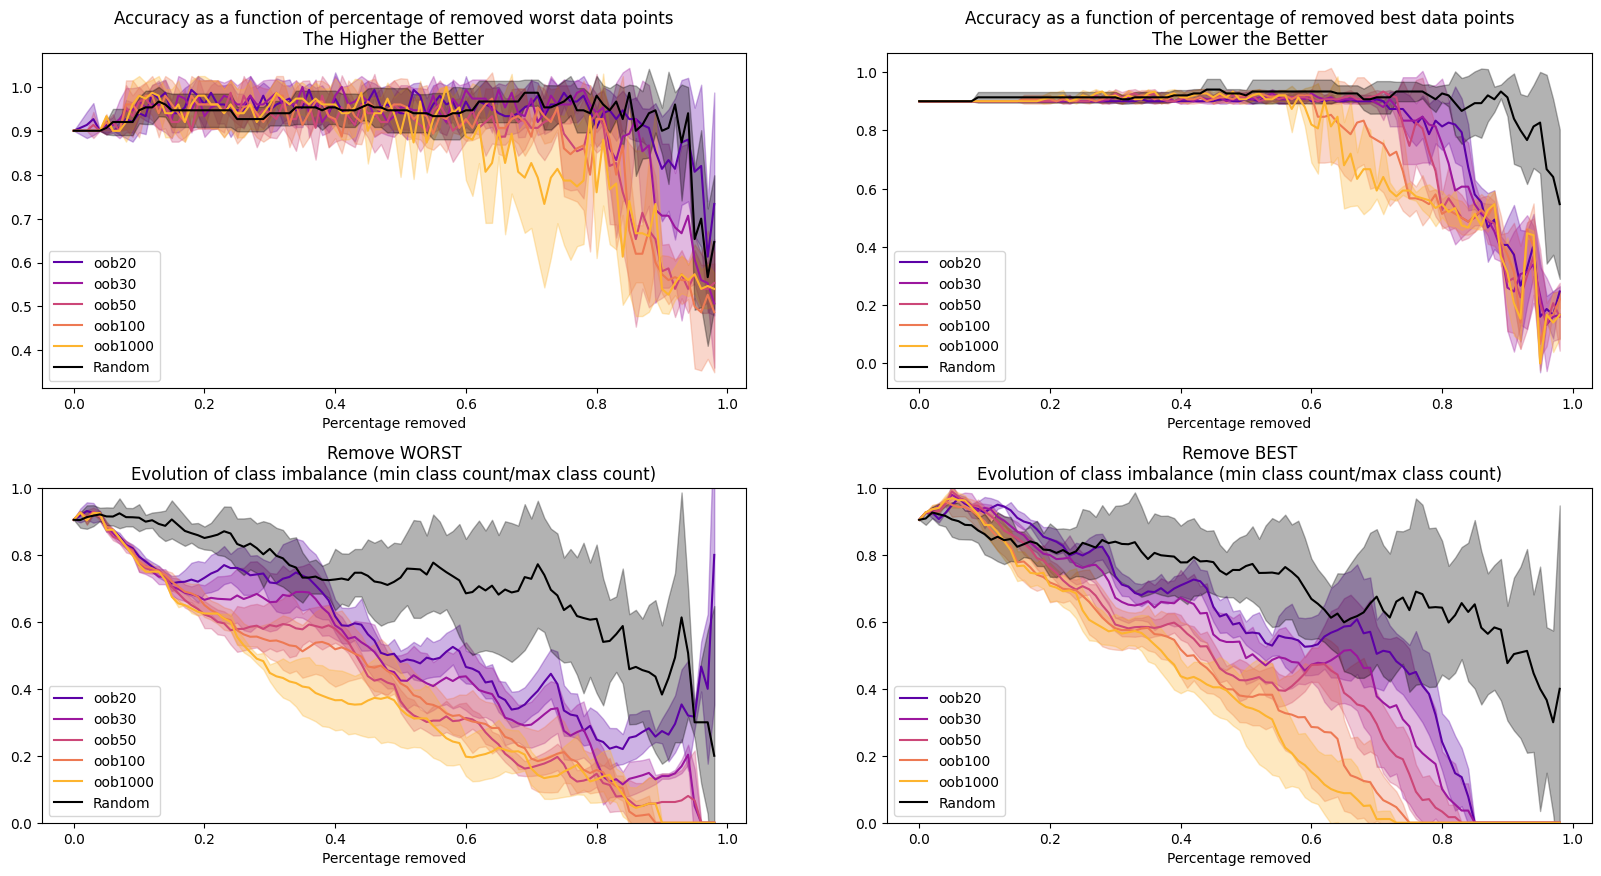

In [11]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="plasma", random_run=True)

# Max_samples

In [12]:
def oob_func(utility, max_samples):
    return(compute_data_oob(utility, n_est=30, max_samples=max_samples, progress=False))
max_samples_list = [x/10 for x in range(1,9,1)]
func = oob_func
kwargs_list = [{"max_samples":max_samp} for max_samp in max_samples_list]


In [16]:
best_scores_df

0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  ...       0.9  \
0   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.233333   
1   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
2   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
3   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
4   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
5   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
6   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
7   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.466667   
8   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
10  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
11  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
12  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.266667   
13  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
14  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
15  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.566667   
16  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.333333   
17  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
18  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
19  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
20  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.333333   
21  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
22  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
23  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
24  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.200000   
25  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.233333   
26  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
27  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.333333   
28  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.333333   
29  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
30  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.566667   
31  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
32  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
33  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
34  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
35  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.300000   
36  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.100000   
37  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.333333   
38  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   
39  0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ...  0.366667   

        0.91      0.92      0.93  0.9400000000000001  0.9500000000000001  \
0   0.233333  0.100000  0.466667            0.466667            0.266667   
1   0.300000  0.300000  0.133333            0.233333            0.166667   
2   0.300000  0.300000  0.300000            0.300000            0.000000   
3   0.166667  0.466667  0.433333            0.166667            0.000000   
4   0.366667  0.300000  0.233333            0.200000            0.000000   
5   0.066667  0.066667  0.066667            0.066667            0.400000   
6   0.366667  0.100000  0.433333            0.433333            0.000000   
7   0.466667  0.533333  0.233333            0.433333            0.466667   
8   0.300000  0.500000  0.266667       

In [13]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

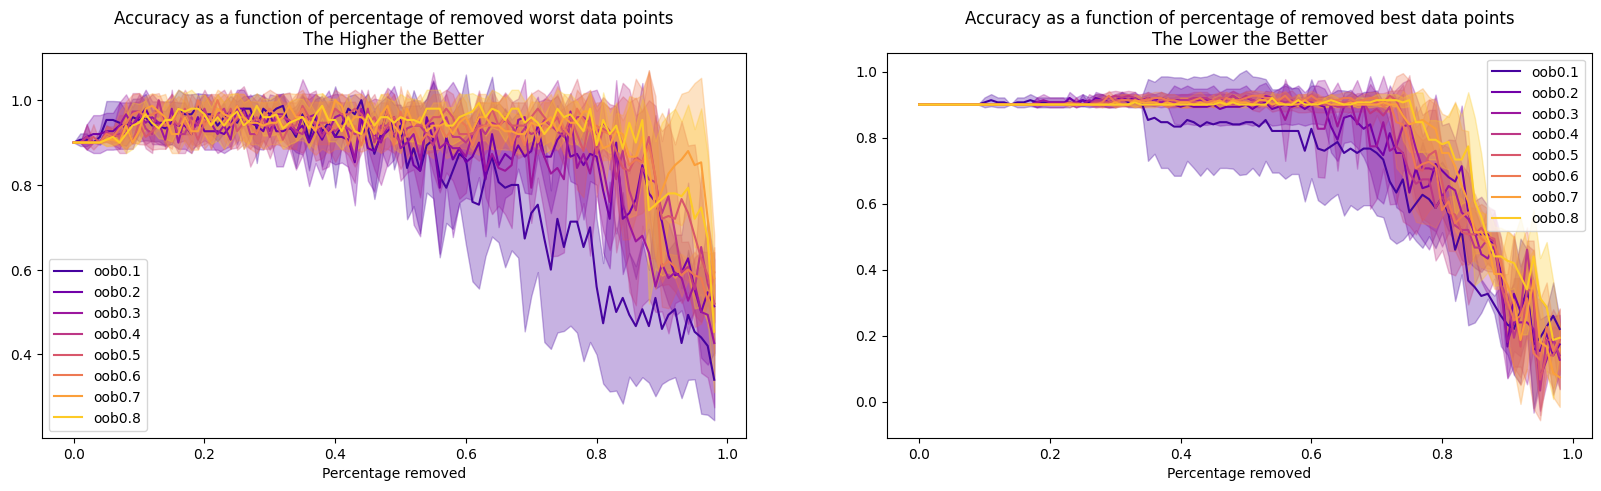

In [14]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

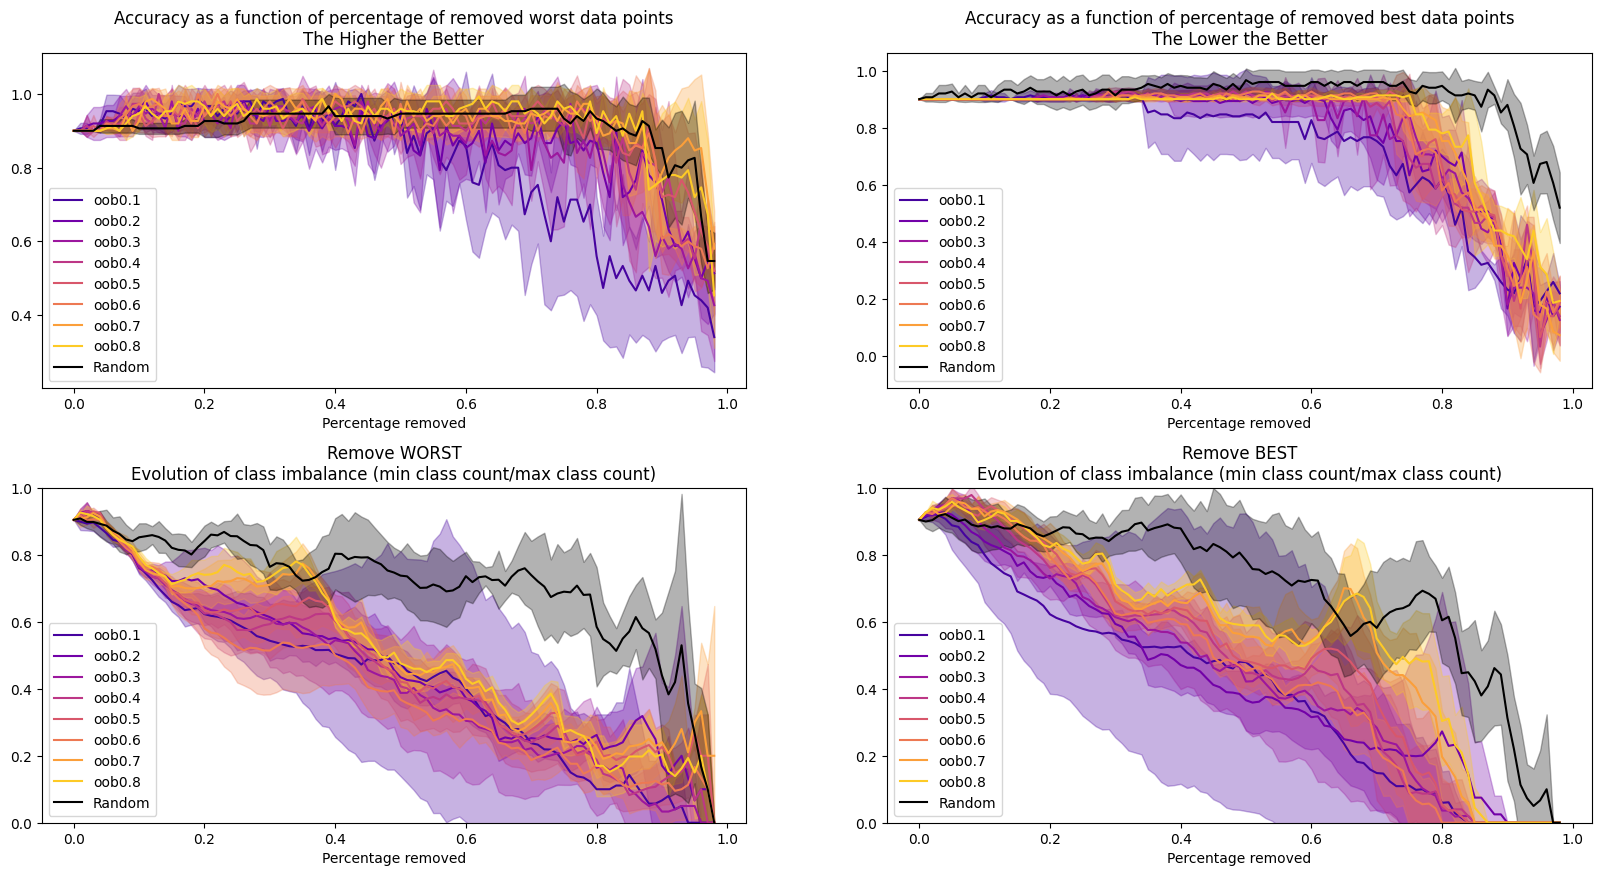

In [15]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="plasma", random_run=True)

# Base estimator

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [ ]:

model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=2,)
model = LogisticRegression()
scorer = Scorer("accuracy", default=0.0)
dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
#utility_lr = Utility(LogisticRegression(), data, scorer)
#dict_utilities["KNN"] = utility_knn
utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest', 'AdaBoost', 'LGBM'])

In [ ]:
list(dict_utilities.keys())

['KNN',
 'DecisionTreeShallow',
 'DecisionTreeDeep',
 'RandomForest',
 'AdaBoost',
 'LGBM']

In [ ]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=30, max_samples=0.8, progress=False))
max_samples_list = np.arange(0.1,0.90,0.1)
func = oob_func
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [ ]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

In [ ]:
best_scores_df

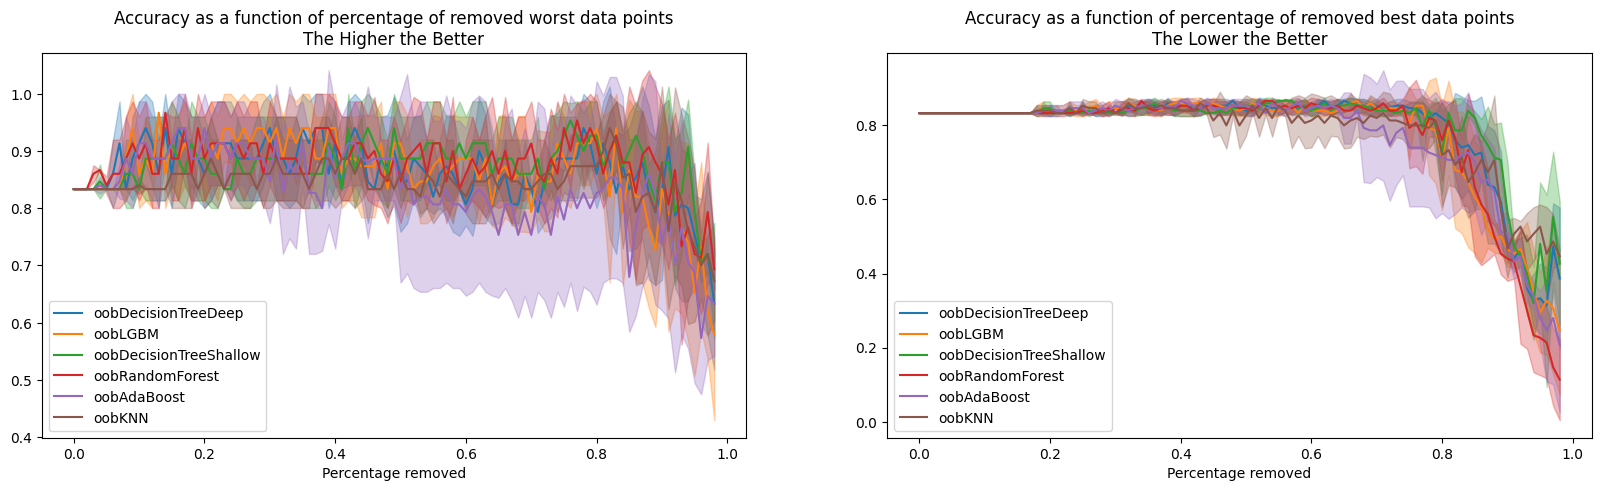

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="tab10")

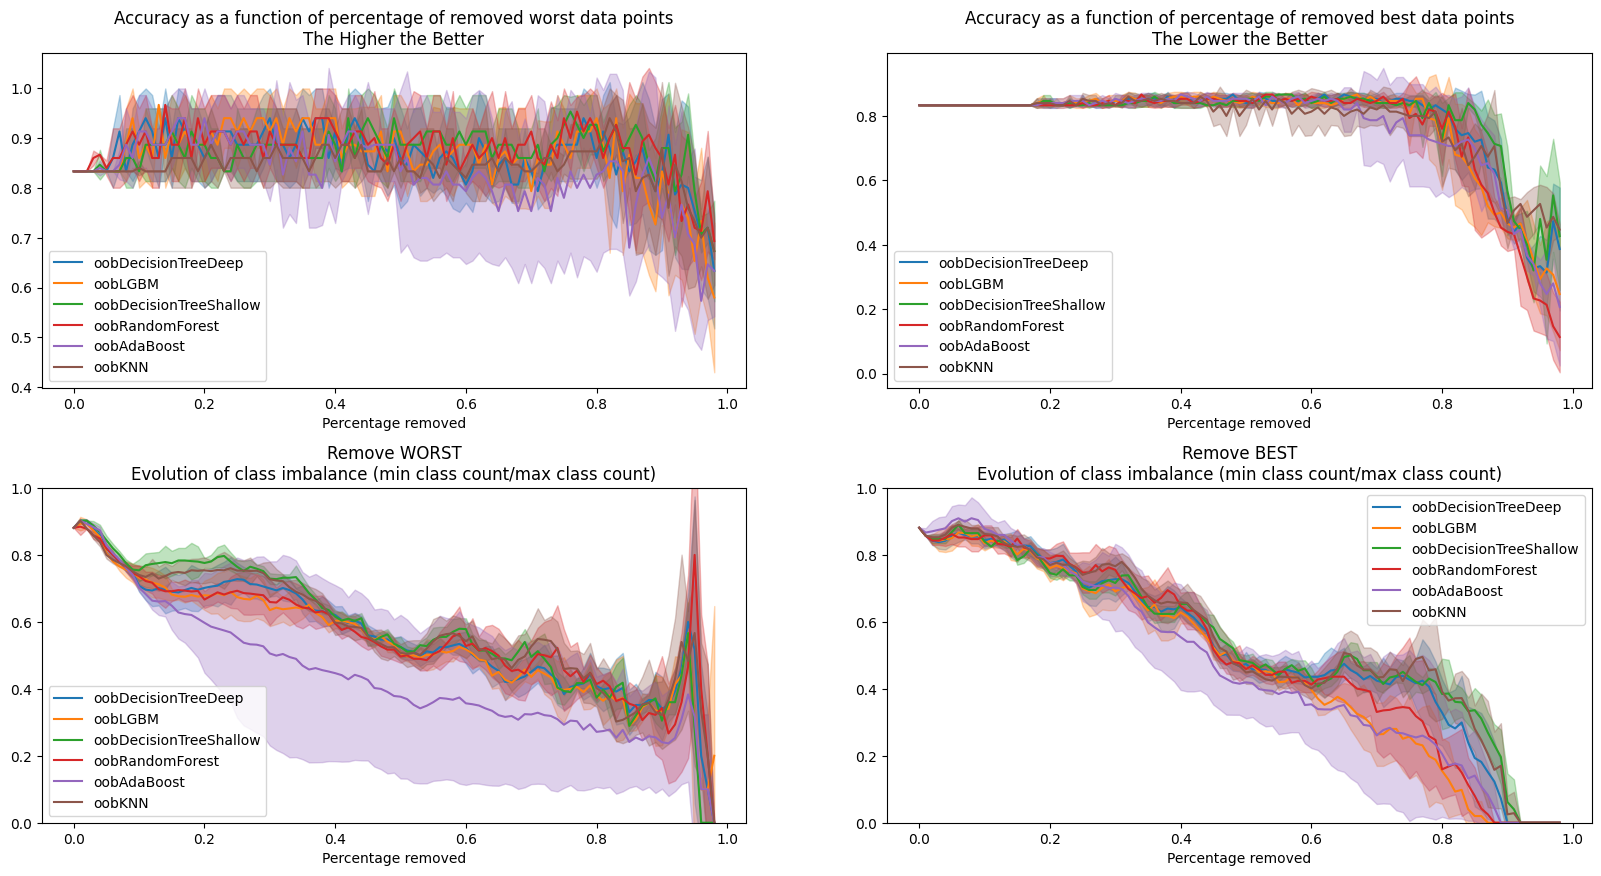

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="tab10")

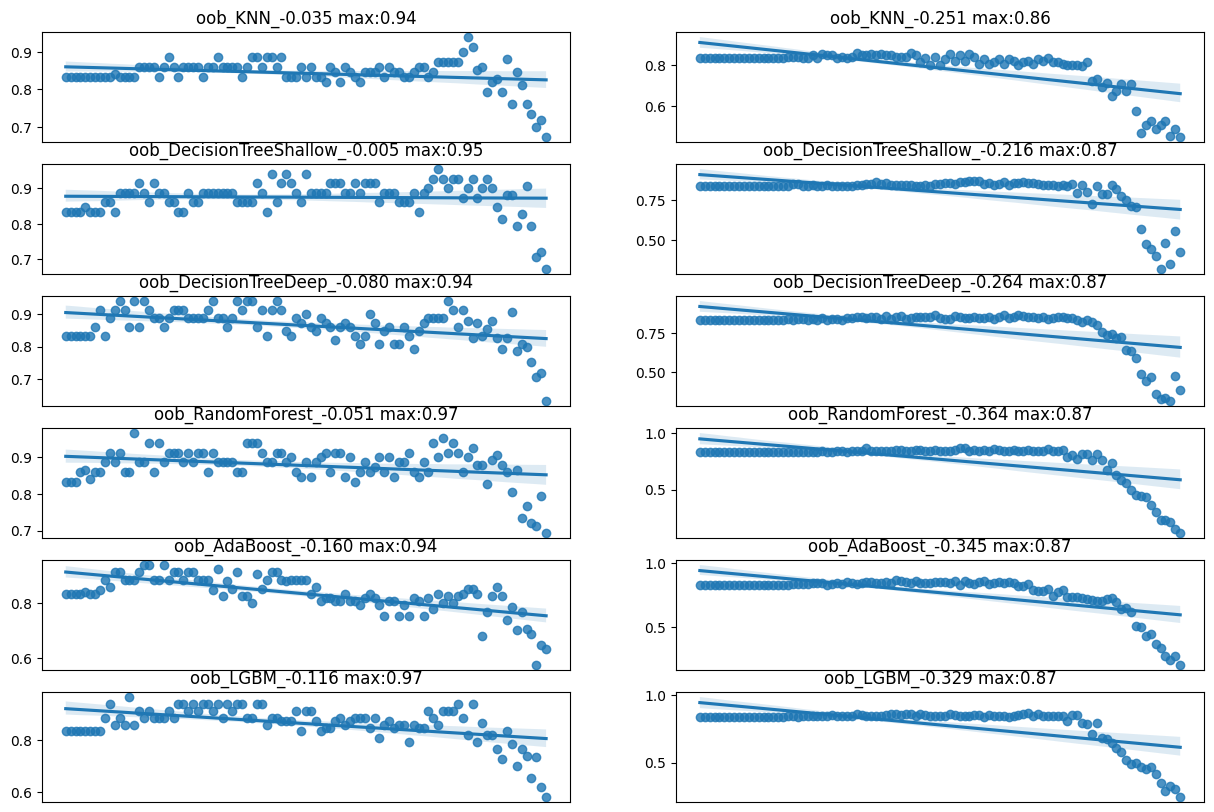

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=best_scores_df.method_name.nunique(), figsize = [15,10])
for i, x in enumerate(best_scores_df.method_name.unique()):
    p=sns.regplot(x=np.arange(len(best_scores_df.groupby("method_name").mean().values[i])), y =best_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,1])
    y_data = p.get_lines()[0].get_ydata()
    maxi = best_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,1].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,1].set_xticks([])
    p=sns.regplot(x=np.arange(len(worst_scores_df.groupby("method_name").mean().values[i])), y =worst_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,0])
    y_data = p.get_lines()[0].get_ydata()
    maxi = worst_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,0].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,0].set_xticks([])